In [40]:
from __future__ import annotations

import particle_in_a_box as pib
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import default_plot as dp

plt.rcParams["text.usetex"] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Dejavu Serif'
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['animation.writer'] = 'ffmpeg'
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['axes.labelsize'] = 10
plt.rcParams["xtick.direction"] = "inout"
plt.rcParams["ytick.direction"] = "inout"

In [10]:
# Demo State
L = np.pi
m = 1
gamma = 10000
states = [5]
amps = [1]
theta = 0

pib_state_1 = pib.Particle_in_Box_State("symmetric", L, m, states, amps, gamma, 0)
pib_state_2 = pib.Particle_in_Box_State("symmetric", L, m, states, amps, gamma, np.pi)


adding state(s):  [5]
current config:  [5]
adding state(s):  [5]
current config:  [5]


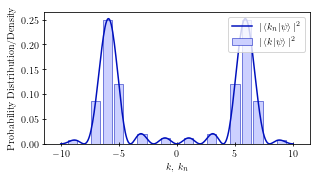

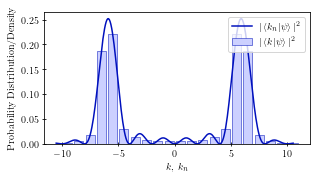

In [55]:
# Create Plots showing the single energy state momentum distributions for different values of theta
fig1 = plt.figure(tight_layout = True, figsize=(4.5,2.5))
p1 = dp.Momentum_Space_Plot(pib_state_1, fig1)
p1.set_n_bound(10)
p1.plot(0)
p1.k_lines[0].set_label(r"$\vert \left \langle k_n \middle \vert \psi \right \rangle \vert^2$")
p1.k_bars.set_label(r"$\vert \left \langle k \middle \vert \psi \right \rangle \vert^2$")
p1.axis.legend(loc="upper right")
plt.savefig("..\\Thesis\\Figures\\dirichlet_5th_state_momentum_distr_theta_0.pdf")

fig2 = plt.figure(tight_layout = True, figsize=(4.5,2.5))
p2 = dp.Momentum_Space_Plot(pib_state_2, fig2)
p2.set_n_bound(10)
p2.plot(0)
p2.k_lines[0].set_label(r"$\vert \left \langle k_n \middle \vert \psi \right \rangle \vert^2$")
p2.k_bars.set_label(r"$\vert \left \langle k \middle \vert \psi \right \rangle \vert^2$")
#p1.axis.tick_params('y', left=False, right=True, labelleft=False, labelright=True)
p2.axis.legend(loc="upper right")
plt.savefig("..\\Thesis\\Figures\\dirichlet_5th_state_momentum_distr_theta_pi.pdf")